In [1]:
# Some libraries
from scipy import *
from math import *
from matplotlib.pyplot import *
from functools import *
import sys
from tqdm import tqdm
import time

In [2]:
from sympy.geometry import Point
from sympy.geometry import Polygon as SimpyPolygon
import math
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pyclipper
import functools

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Class and converting functions

In [3]:
class Rectangle:
    """Minimal representation of a rectangle"""
    def __init__(self, point1_x, point1_y, point2_x, point2_y, longueur):
        self.point1_x = point1_x
        self.point1_y = point1_y
        self.point2_x = point2_x
        self.point2_y = point2_y
        self.longueur = longueur
        
    def side_length(self):
        return math.sqrt((self.point2_x - self.point1_x)**2 + (self.point2_y - self.point1_y)**2)
    
    def area(self):
        return abs(self.side_length() * self.longueur)
    
#     def to_rect(self, strategy="Default"):
#         """Convert a minimal rectangle to a full rectangle"""
#         point1 = Point(self.point1_x, self.point1_y)
#         point2 = Point(self.point2_x, self.point2_y)
#         if point1.equals(point2):
#             raise ValueError("Point 1 and point 2 are the same")
#         if self.longueur == 0:
#             raise ValueError("Longueur nulle interdite")
#         longueur = self.longueur
#         vect = (point2.x - point1.x, point2.y - point1.y)
#         distance = point1.distance(point2)
#         vectUnitaire = (vect[0] / distance * longueur, vect[1] / distance * longueur)
#         normalVect = (-vectUnitaire[1], vectUnitaire[0])
#         point3 = Point(point2.x + normalVect[0], point2.y + normalVect[1])
#         point4 = Point(point1.x + normalVect[0], point1.y + normalVect[1])
#         if strategy == "Default":
#             return [point1, point2, point3, point4]
#         else:
#             return SimpyPolygon(point1, point2, point3, point4)
        
    def to_rect(self, strategy="Default"):
        """Convert a minimal rectangle to a full rectangle"""
        vect = (self.point2_x - self.point1_x, self.point2_y - self.point1_y)
        distance = self.side_length()
        vectUnitaire = (vect[0] / distance * self.longueur, vect[1] / distance * self.longueur)
        normalVect = (-vectUnitaire[1], vectUnitaire[0])
        point1 = (self.point1_x, self.point1_y)
        point2 = (self.point2_x, self.point2_y)
        point3 = (self.point2_x + normalVect[0], self.point2_y + normalVect[1])
        point4 = (self.point1_x + normalVect[0], self.point1_y + normalVect[1])
        if strategy == "Default":
            return [point1, point2, point3, point4]
        else:
            return SimpyPolygon(point1, point2, point3, point4)

In [4]:
# def path_to_polygon(path):
#     """Return a polygon if it is not one yet"""
#     if type(path) == list:
#         return SimpyPolygon(*path)
#     return path

# def polygon_to_path(polygon):
#     """Return a path if it is not one yet"""
#     if type(polygon) == SimpyPolygon:
#         return list(map(lambda p: [p.x, p.y], polygon.vertices))
#     return polygon

## Drawing functions

In [5]:
def draw_polygon(polygon, ax=None, color="green"):
    """Draw a polygon over an axis (not shown directly)
    
    @param polygon: Whether a polygon or a path
    """
    if ax is None:
        ax = plt.gca()
    if type(polygon) == SimpyPolygon:
        polygon = np.array(list(map(lambda p: [p.x, p.y], polygon.vertices)))
    p = Polygon(polygon, closed=False, color=color, alpha=0.3, lw=0)
    ax.add_patch(p)
    ax.axis('equal')
    return ax

In [6]:
def draw_polygons(polygons, colors=None, verbose=False):
    """Draw polygons and print the figure
    
    @param polygons: SimpyPolygon or list(SimpyPolygon)
    @param colors: colors to match to the polygons
    """
    ax = plt.gca()
    if type(polygons) == SimpyPolygon:
        polygons = [polygons]
    if colors is None:
        colors = ["grey"]*len(polygons)
    if len(colors) > 0 and len(colors) < len(polygons):
        colors = colors + [colors[-1]] * (len(polygons) - len(colors))
    colors.reverse()
    
    for polygon in polygons:
        color = colors.pop()
        if verbose:
            print(color, "Polygon : ", polygon)
        ax = draw_polygon(polygon, ax, color=color)
    plt.show()

In [7]:
counts = {}
def log_polygons(land, sols, colors=["green", "brown"], legend="Best", padding=1):
    global counts
    if not legend in counts.keys():
        counts[legend] = 0
    counts[legend] +=1
    if (counts[legend] % padding == 0):
        sols = list(sols) if type(sols) == map else [sols]
        legend_text = " : " + legend if legend is not None else ""
        printmd("### Itération "+str(counts[legend])+legend_text)
        polygons = [land]+[Rectangle(*sol).to_rect() for sol in sols]
        draw_polygons(polygons, colors)

## Calculate the area of a polygon

In [8]:
def get_bornage_search_field(polygon):
    polygon = polygon_to_path(polygon)
    min_func = lambda acc, vertice: min(min(*vertice),acc)
    max_func = lambda acc, vertice: max(max(*vertice),acc)
    
    min_search_field = functools.reduce(min_func, polygon, sys.maxsize)
    max_search_field = functools.reduce(max_func, polygon, -sys.maxsize)
    
    return min_search_field, max_search_field

## Calculate the validity of a solution

In [11]:
def vertice_in_polygon(vertice, polygon):
    """ Determine if the vertice is in the polygon
    Not a strict check because of the pyclipper library in which
    the coordinates are floored.
    """
    return list(map(lambda c: int(c), vertice)) in polygon

def is_valid(rectangle, polygon, verbose=False):
    """ Determine if the rectangle is in the polygon
    
    @param rectangle: whether a polygon or a list of vertices
    @param polygon: whether a polygon or a list of vertices
    """
    if verbose:
        print("entrée: est_valide")
        start_time = time.time()
    try:
        pc = pyclipper.Pyclipper()
        pc.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        pc.AddPath(rectangle, pyclipper.PT_CLIP, True)
    
        intersections = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        
        res = (intersections != []) and (len(intersections[0]) == len(rectangle)) and np.all([vertice_in_polygon(v, intersections[0]) for v in rectangle]) 
        if verbose:
            print("--- %s seconds ---" % (time.time() - start_time))
        return res
    except pyclipper.ClipperException:
        print("Clipper exception")
        return False

# def isValid_Nico(polygon, sol):
#     x1, y1, x2, y2, length = sol
    
#     if(dist(x1, y1, x2, y2) >= SIZE and length >= SIZE):
#         rectangle = sol2rect(sol)
        
#         # test intersection
#         pc = pyclipper.Pyclipper()
#         pc.AddPath(polygon, pyclipper.PT_CLIP, True)
#         try:
#             pc.AddPath(rectangle, pyclipper.PT_SUBJECT, True)
#         except:
#             print("rectangle invalide ", rectangle)
#         intersect = pc.Execute(pyclipper.CT_INTERSECTION, pyclipper.PFT_EVENODD, pyclipper.PFT_EVENODD)
        
#         if len(intersect) > 0:
#             return sorted(intersect[0]) == sorted([[int(x), int(y)] for [x,y] in rectangle])
    
#     return False

House : [(0, 100), (0, 0), (100.0, 0.0), (100.0, 100.0)]
Land : [(0, 0), (0, 100), (100, 100), (110, 50), (100, 0)]


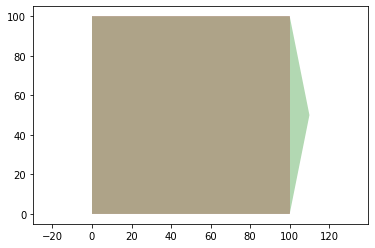

### Validité : C'est bon ça passe

### L'aire de la maison est de **10000** m² sur 10500 m² possible



green Polygon :  [(0, 0), (0, 100), (100, 100), (110, 50), (100, 0)]
brown Polygon :  [(0, 100), (0, 0), (100.0, 0.0), (100.0, 100.0)]


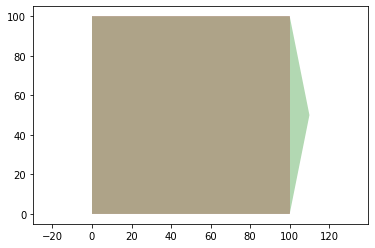

In [17]:
solution = Rectangle(0, 100, 0, 0, 100)
house = solution.to_rect()
print("House :", house)

land = [(0,0), (0,100), (100,100), (110, 50), (100, 0)]
print("Land :", land)

# draw the situation
draw_polygons([land, house], colors=["green", "brown"], verbose=False)

# determine if the house is well placed over the land
res = is_valid(house, land)
printmd("### Validité : C'est bon ça passe" if res else "### Validité : Noooooooon, construction incorrecte")
printmd(f"### L'aire de la maison est de **{int(solution.area())}** m² sur {abs(SimpyPolygon(*land).area)} m² possible\n\n")

# draw the solution to verify it is correct
draw_polygons([land, house], colors=["green","brown","blue"], verbose=True)

In [19]:
# get_bornage_search_field(land)

In [20]:
def polygon_bornage(sol, land_polygon, verbose=False):
    if verbose:
        print("entrée: polygon_bornage")
    rect = Rectangle(*sol).to_rect()
    if is_valid(rect, land_polygon):
        if verbose:
            print(sol)
            printmd("## Est valide")
        return sol 
    else:
        if verbose:
            print("this one is invalid")
        # print(sol)
        raise ValueError("Solution invalide par contrainte de bornage")

In [21]:
# inf, sup = get_bornage_search_field(land)
# PSO_fit(eval_function=area, 
#         bornage_function=lambda x: polygon_bornage(x, land), 
#         log_function=lambda x:draw_polygons([land, sol_to_rect(x)], colors=["green", "brown"]), 
#         nb_particle=20, 
#         dim=5, inf=inf, sup=sup, 
#         nb_cycles=3)

6326.845514841912
True


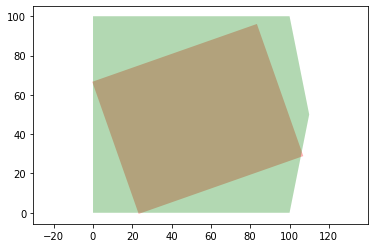

In [22]:
sol = Rectangle(-10.7347279703318*(2/5 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 0.0198738320514325*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 4/5) + 0.00218857078076901*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 5.670410197948, 0.00431885917779833*sqrt(26)*(3/5 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 2.52532539044785*sqrt(26) + 52.8630195088222, -2.69787695407254e-5*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) + 0.0747623975868827*(sqrt(26)/5 + 3)*(-200/(20*sqrt(26) + 300) - 20*sqrt(26)/(20*sqrt(26) + 300) + 9/10) + 0.0302304645174633*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 22.2758734670769*(3/10 - 100/(20*sqrt(26) + 300))*(sqrt(26)/5 + 3) + 78.6016046287042, -0.0296283300402663*sqrt(26)*(1/2 - 200/(20*sqrt(26) + 300))*(20*sqrt(26) + 300) + 0.265934510467706*sqrt(26) + 0.0101730402884402*sqrt(26)*(20*sqrt(26) + 300)*(-200/(20*sqrt(26) + 300) - 10*sqrt(26)/(20*sqrt(26) + 300) + 7/10) + 93.2932548940824, -71.25376384331184)
print(sol.area())
print(is_valid(sol.to_rect(),land))
draw_polygons(polygons=[sol.to_rect(), land], colors=["red", "green"])

In [23]:
Nb_cycles = 2000
Nb_particle = 20
# usual params
psi,cmax = (0.4, 1.12)
# psi,cmax = (0,7, 1,47)
# psi,cmax = (0.8, 1.62)

### Calcul de temps

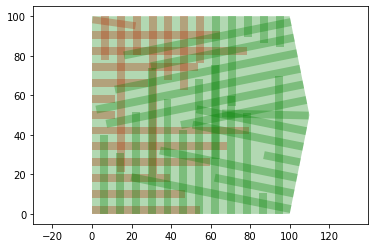

<ipython-input-25-32349281ae20>:20: DeprecationWarning: scipy.all is deprecated and will be removed in SciPy 2.0.0, use numpy.all instead
  print("Tous valides ? ", list(all(is_valid(sol, land) for sol in sols)))


Tous valides ?  [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [25]:
from sympy import Symbol
def pick_random_sol(land, size=1, delta=0.05, stochastic=False):
    t = Symbol('t', real=True)
    p = SimpyPolygon(*land).arbitrary_point('t')
    if stochastic:
        picks = sorted([random.rand() for i in range(size*2)])
    else:
        picks = np.linspace(0, 1, size*2+1)
    points_on_perimeter = [p.subs(t, pick) for pick in picks]
    #picks = [pick + delta if pick + delta < 1 else pick + (1 - pick) / 2 for pick in picks]
    #second_points_on_perimeter = [p.subs(t, pick) for pick in picks]
    sols = [[points_on_perimeter[i*2].x, points_on_perimeter[i*2].y, points_on_perimeter[i*2+1].x, points_on_perimeter[i*2+1].y, -10-delta*2000*random.rand()] for i in range(size)]
    for sol in sols:
        while not is_valid(Rectangle(*sol).to_rect(), land):
            sol[4] = sol[4] / 2
    return sols
    # return p.subs(t, (s1 + s2/2)/perimeter)
sols = [Rectangle(*sol).to_rect() for sol in pick_random_sol(land, 50)]
draw_polygons([*sols, land], colors=["red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "red", "green"])
print("Tous valides ? ", list(all(is_valid(sol, land) for sol in sols)))

In [26]:
st = time.time()
for sol in pick_random_sol(land, 50):
    pass
print(time.time() - st)

5.970958948135376


In [27]:
# Initialization

# create a particle 
# one particle is discribed by : 
#   - pos : solution list of variables
#   - vit : movement velocity (null at the initialization)
#   - fit :  fitness of the solution
#   - bestpos : best visited position 
#   - bestfit : evaluation of the best visited solution
#   - bestvois : best neighbor (global for this version)
# def initOne(dim,inf,sup, eval_func=FUNCTION):
#     pos = [random.uniform(inf, sup) for i in range(dim)]
#     fit = eval(pos, eval_func)
#     return {'vit':[0]*dim, 'pos':pos, 'fit':fit, 'bestpos':pos, 'bestfit':fit, 'bestvois':[]}


# Init of the population (swarm)
def initSwarm(nb,dim,eval_func,land=None):
    positions = pick_random_sol(land, nb)
    fits = [eval_func(pos) for pos in positions]
    return [{'vit':[0]*dim, 'pos':positions[i], 'fit':fits[i], 'bestpos':positions[i], 'bestfit':fits[i], 'bestvois':[]} for i in range(nb)]

In [28]:
# Return the particle with the best fitness
def maxParticle(p1,p2):
    if (p1["fit"] > p2["fit"]):
        return p1 
    else:
        return p2

# Returns a copy of the particle with the best fitness in the population
def getBest(swarm):
    return dict(reduce(lambda acc, e: maxParticle(acc,e),swarm[1:],swarm[0]))

In [29]:
# Update information for the particles of the population (swarm)
def update(particle,bestParticle):
    nv = dict(particle)
    if(particle["fit"] > particle["bestfit"]):
        nv['bestpos'] = particle["pos"][:]
        nv['bestfit'] = particle["fit"]
    nv['bestvois'] = bestParticle["bestpos"][:]
    return nv

# Calculate the velocity and move a particule
def move(particle, dim, eval_function, bornage_function, verbose=False):
    global psi,cmax

    if verbose:
        print("entrée: move")
    nv = dict(particle)

    velocity = [0]*dim
    for i in range(dim):
        velocity[i] = (particle["vit"][i]*psi + \
        cmax*random.uniform()*(particle["bestpos"][i] - particle["pos"][i]) + \
        cmax*random.uniform()*(particle["bestvois"][i] - particle["pos"][i]))

    new_pos = [particle["pos"][i] + velocity[i] for i in range(dim)]
    
    start_time = time.time()
    try:
        position = bornage_function(new_pos)   
    except ValueError:
        position = particle["pos"]
    if verbose:
        print("--- Bornage: %s seconds ---" % (time.time() - start_time))
    
    nv['vit'] = velocity
    nv['pos'] = position
    nv['fit'] = eval_function(position)
    if verbose:
        print("Debug: ", particle["pos"], "is the previous solution")
        print("Debug: ", new_pos, "is the new solution")
        print("sortie: move")
    return nv

In [31]:
dim = 5
eval_function = lambda x: Rectangle(*x).area()
bornage_function = lambda x: polygon_bornage(x, land)
log_function = lambda x,legend=None,padding=100,colors=["green", "red"]:log_polygons(land, x, colors, legend, padding)

start_time = time.time()
swarm = initSwarm(20,dim,eval_func=eval_function, land=land)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
best = getBest(swarm)
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
swarm = [update(e,best) for e in swarm]
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
swarm = [move(particle=e, dim=dim, eval_function=eval_function, bornage_function=bornage_function) for e in swarm]
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
log_function(map(lambda s: s["pos"], swarm), colors=["green", "purple"], legend="Swarm")
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()
[bornage_function(e["pos"]) for e in swarm]
print("--- %s seconds ---" % (time.time() - start_time))
rects = [Rectangle(*e["pos"]).to_rect() for e in swarm]
start_time = time.time()
[is_valid(r, land) for r in rects]
print("--- %s seconds ---" % (time.time() - start_time))

--- 3.395998954772949 seconds ---
--- 5.650520324707031e-05 seconds ---
--- 7.82012939453125e-05 seconds ---
--- 2.4676058292388916 seconds ---
--- 8.869171142578125e-05 seconds ---
--- 1.921372652053833 seconds ---
--- 1.610063076019287 seconds ---


In [32]:
# MAIN LOOP
LAND = land
def fit(eval_function, bornage_function, nb_particle=Nb_particle, dim=5, nb_cycles=Nb_cycles, log_function=print):
    Htemps = []       # temps
    Hbest = []        # distance

    # initialization of the population
    swarm = initSwarm(nb_particle,dim,eval_func=eval_function, land=LAND)
    log_function(map(lambda s: s["pos"], swarm), colors=["green", "purple"], legend="Initialization", padding=1)
    # initialization of the best solution
    best = getBest(swarm)
    best_cycle = best

    for i in tqdm(range(nb_cycles)):
        #Update informations
        swarm = [update(e,best_cycle) for e in swarm]
        # velocity calculations and displacement
        swarm = [move(particle=e, dim=dim, eval_function=eval_function, bornage_function=bornage_function) for e in swarm]
        log_function(map(lambda s: s["pos"], swarm), colors=["green", "purple"], legend="Swarm")
        # Update of the best solution
        best_cycle = getBest(swarm)
        if (best_cycle["bestfit"] > best["bestfit"]):
            best = best_cycle
            # draw(best['pos'], best['fit'])

        # historization of data
        if i % 10 == 0:
            Htemps.append(i)
            Hbest.append(best['bestfit'])
            
        log_function(best['pos'], legend="Best", colors=["green", "blue"])

    # END, displaying results
    Htemps.append(i)
    Hbest.append(best['bestfit'])

    #displaying result on the console
    print(best)

### Itération 1 : Initialization

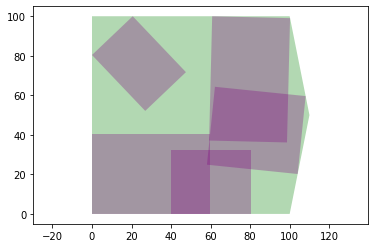

  5%|▌         | 10/200 [00:07<02:19,  1.36it/s]


KeyboardInterrupt: 

In [34]:
fit(eval_function=lambda x: Rectangle(*x).area(), 
    bornage_function=lambda x: polygon_bornage(x, land), 
    log_function=lambda x,legend=None,padding=100,colors=["green", "red"]:log_polygons(land, x, colors, legend, padding),
    nb_particle=5, 
    dim=5, 
    nb_cycles=200)